In [1]:
# This notebook is for internal Apps Ops to quickly build simple models for v5 Orca
# Uses a simplified assumptions for most tools
# Single best estimator for each base model visnir and exnir
# Uses existing pptoolbox functions as much as possible

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import cross_val_predict, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay

from pptoolbox.platform.preprocessing import preprocess_v2
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.pipelines import META_CLASSIFIER_PIPELINES, META_REGRESSION_PIPELINES

# import sys
# sys.path.append("../src")
# from utils.pipelines_meta import META_CLASSIFIER_PIPELINES # Shifted into pptoolbox 1.3.1

### Helper Utils

In [3]:
# Dumping meta utils here. 
# Algorithm design still undergoing testing. not yet stable for pptoolbox?
import warnings
from typing import Literal, Optional
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import BaseCrossValidator, cross_val_predict


AUTOML_MODE_OPTIONS = ["classify", "profile"]

def create_meta_datasets_splits(
    estimators: list[list[Pipeline]],
    datasets: list[pd.DataFrame],
    y: pd.Series,
    groups: np.ndarray,
    outer_cv: BaseCrossValidator,
    inner_cv: BaseCrossValidator,
    mode: Literal[AUTOML_MODE_OPTIONS] = "classify",
) -> tuple[pd.DataFrame, pd.Series, np.ndarray]:
    """
    Custom pre-processing for meta-model cross validation flow
    This flow assumes we maintain the same split indexes across all hyperparams to be tested.
    Because of this, we can pre-calculate the features being input to meta-model
    Instead of re-fitting the same estimator at each fold
    """
    if mode not in AUTOML_MODE_OPTIONS:
        raise ValueError(f"Unexpected mode: {mode}. Expected {AUTOML_MODE_OPTIONS}")
    if len(datasets) == 1:
        raise ValueError(
            "This is meant for data fusion. Check your input is a List of pandas.DataFrame"
        )

    for X in datasets[1:]:
        if len(X) != len(datasets[0]):
            raise IndexError(
                f"Lengths of input datasets do not match ({datasets[0].shape[0]}), ({X.shape[0]})"
            )

    for i, estimator_list in enumerate(estimators):
        if type(estimator_list) != list:
            if type(estimator_list) == Pipeline:
                warnings.warn("Single estimator detected. Converting to list")
                estimators[i] = [estimator_list]
            else:
                raise ValueError("estimators should be a list of lists of Pipelines")

    if len(datasets) != len(estimators):
        raise ValueError(
            "Length of datasets and estimators do not match. Check your inputs"
        )

    if mode == "classify":
        n_classes = len(np.unique(y))
    else:
        n_classes = 1

    n = len(datasets[0])
    m_list = [0] + [len(estimator_list) for estimator_list in estimators]
    m = sum(m_list) * n_classes
    k = outer_cv.get_n_splits()

    new_indices = np.concatenate([datasets[0].index] * k)
    meta_X = np.zeros((n * k, m))
    meta_y = pd.Series(np.concatenate([y] * k), index=new_indices)
    splits_idx = np.zeros((n * k, 2))

    for fold_idx, (train_idx, test_idx) in enumerate(
        outer_cv.split(datasets[0], y, groups=groups)
    ):
        y_train = y.iloc[train_idx]
        splits_idx[n * fold_idx : n * (fold_idx + 1), 0] = fold_idx
        splits_idx[test_idx + (n * fold_idx), 1] = 1

        for i in range(len(datasets)):
            X = datasets[i]
            for j, estimator in enumerate(estimators[i]):
                X_train = X.iloc[train_idx]
                X_test = X.iloc[test_idx]

                if mode == "classify":
                    # Classification Flow
                    preds_train = cross_val_predict(
                        estimator,
                        X_train,
                        y_train,
                        groups=X_train.index,
                        cv=inner_cv,
                        method="predict_proba",
                    )
                    estimator.fit(X_train, y_train)
                    preds_test = estimator.predict_proba(X_test)
                else:
                    # Regression Flow
                    preds_train = cross_val_predict(
                        estimator,
                        X_train,
                        y_train,
                        groups=X_train.index,
                        cv=inner_cv,
                        method="predict",
                    )
                    estimator.fit(X_train, y_train)
                    preds_test = estimator.predict(X_test)

                meta_X[
                    train_idx + n * fold_idx,
                    n_classes * (j + m_list[i]) : n_classes * (j + 1 + m_list[i]),
                ] = preds_train.reshape(X_train.shape[0], n_classes)
                meta_X[
                    test_idx + n * fold_idx,
                    n_classes * (j + m_list[i]) : n_classes * (j + 1 + m_list[i]),
                ] = preds_test.reshape(X_test.shape[0], n_classes)

    meta_X = pd.DataFrame(meta_X, index=new_indices)

    return meta_X, meta_y, splits_idx


class CustomMetaSplitter(BaseCrossValidator):
    def __init__(self, split_idx: np.ndarray):
        self.splits = split_idx
        self.n_splits = len(np.unique(split_idx[:, 0]))

    def get_n_splits(
        self, X: Optional = None, y: Optional = None, groups: Optional = None
    ) -> int:
        return self.n_splits

    def split(self, X: Optional = None, y: Optional = None, groups: Optional = None):
        for i in range(self.n_splits):
            train_idx = np.where((self.splits[:, 0] == i) & (self.splits[:, 1] == 0))[0]
            test_idx = np.where((self.splits[:, 0] == i) & (self.splits[:, 1] == 1))[0]
            yield train_idx, test_idx



In [4]:
def initialise_trainer(task_type ='classify', log=False, experiment_name='', mlflow_uri=None, *args, **kwargs):
    trainer = AutoML_v4(task_type = task_type, log = log, *args, **kwargs, exploration_runs=100) # !updated exploration runs
    if log == True:
        trainer.set_log_config(
            experiment_name = f"{experiment_name}",
            mlflow_uri = mlflow_uri
        )
    return trainer

In [5]:
def generate_metafeatures_classify(datasets, estimators, y, cv = StratifiedGroupKFold(n_splits=3)):
    n_classes = len(np.unique(y))
    for i, estimator_list in enumerate(estimators):
        if type(estimator_list) != list:
            if type(estimator_list) == Pipeline:
                # warnings.warn("Single estimator detected. Converting to list")
                estimators[i] = [estimator_list]
            else:
                raise ValueError("estimators should be a list of lists of Pipelines")
    n = len(datasets[0])
    m_list = [0] + [len(estimator_list) for estimator_list in estimators]
    m = sum(m_list) * n_classes

    X_meta = np.zeros([n,m])
    for i in range(len(datasets)):
        X = datasets[i]
        for j, estimator in enumerate(estimators[i]):
            y_preds = cross_val_predict(estimator, X, y, groups=X.index, cv=cv, method='predict_proba')

            X_meta[
                :,
                n_classes * (j + m_list[i]) : n_classes * (j + 1 + m_list[i]),
            ] = y_preds.reshape(n, n_classes)
            pass

    return X_meta


In [6]:
"""Combined file simulating platform utils file."""
import pandas as pd
import numpy as np

import os
import pickle as pkl
from typing import Annotated, List, Tuple, Optional

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import confusion_matrix
from pptoolbox.platform.automl_v4 import cross_group_predict
from pptoolbox.platform.automl_v4 import AutoML_v4

# Dump to file
def model_dump_classify(trainer: AutoML_v4, estimator, encoder: LabelEncoder, X: pd.DataFrame, encoded_y: pd.Series, output_dir: str, suffix: str=""):
    # Explicitly separated trainer and model because of the meta_model refit required

    # Dump model
    pkl.dump(
        estimator, 
        open(os.path.join(output_dir, f"origin_model_prediction{suffix}.pkl"), "wb")
    )

    # Dump trainer
    pkl.dump(
        trainer, 
        open(os.path.join(output_dir, f"trainer{suffix}.pkl"), "wb")
    )

    # Calculate CV confusion matrix
    cnfm = generate_classify_confusionmatrix(estimator, X, encoded_y, encoder)
    cnfm.to_csv(os.path.join(output_dir, f"confusion_matrix{suffix}.csv"))

    # Get CV metrics from AutoML trainer
    model_summary = generate_classify_metrics(trainer, name=0)
    model_summary.to_csv(os.path.join(output_dir, f"metrics{suffix}.csv"))
    return None

# Calculate CV confusion matrix
def generate_classify_confusionmatrix(estimator, X, encoded_y, encoder):
    grouped_y = encoded_y.groupby(encoded_y.index).apply(lambda x: x.iloc[0])

    metric_kfold = StratifiedGroupKFold(n_splits = 3)
    grouped_cv_pred = cross_group_predict(
        estimator,
        X,
        y = encoded_y,
        cv = metric_kfold, 
        groups = X.index
    )

    grouped_pred = pd.Series(
        encoder.inverse_transform(grouped_cv_pred), 
        index = grouped_y.index
    )

    grouped_true = pd.Series(
        encoder.inverse_transform(grouped_y),
        index = grouped_y.index
    )

    cnfm = pd.DataFrame(
        confusion_matrix(grouped_true, grouped_pred),
        index = encoder.classes_,
        columns = encoder.classes_
    )
    return cnfm

# Get CV metrics from AutoML trainer
def generate_classify_metrics(trainer, name:str='None'):
    best_trial = trainer.get_best_trial()
    model_summary = pd.Series(
        [
            trainer.get_pipeline_name(),
            best_trial["result"]["cv_results"]["test_balanced_accuracy"],
            best_trial["result"]["cv_results"]["test_f1_micro"],
            best_trial["result"]["cv_results"]["test_precision_micro"],
            best_trial["result"]["cv_results"]["test_recall_micro"]
        ], 
        index = [
            "model",
            "balanced_accuracy",
            "f1_score",
            "precision",
            "recall"
        ], 
        name = name
    )
    return model_summary


### Init

In [7]:
# Initialise configs
sql_response_file = Path("../data/processed/input.csv")
labels_file = Path("../data/processed/label.csv")

experiment_name = "ketchup classify"

input_df = pd.read_csv(sql_response_file) 
labels_df = pd.read_csv(labels_file)

# Rename the qmini, qneo columns to align with automl_orca hardcoded names
# mapper = {
#     "calc_data_mini": "raw_data_mini",
#     "calc_data_neo": "raw_data_neo",
# }
# input_df = input_df.rename(mapper=mapper, axis=1)

N_SPLITS = 3
DEFAULT_CV = StratifiedGroupKFold(n_splits=N_SPLITS)

In [8]:
labels = labels_df.select_dtypes('object').drop(columns=['lot_name'])

### full loop

origin
visnir
 96%|█████████▌| 240/250 [00:23<00:00, 10.29trial/s, best loss: 0.19444444444444464]
model                SG2D-Scaler-GaussianNB
balanced_accuracy                  0.805556
f1_score                           0.801587
precision                          0.801587
recall                             0.801587
Name: visnir, dtype: object


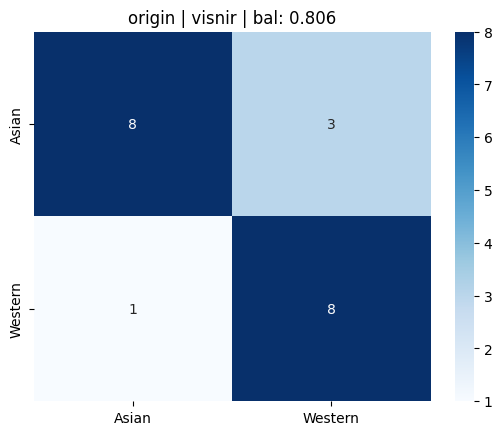

exnir
100%|██████████| 250/250 [00:21<00:00, 11.41trial/s, best loss: 0.20833333333333337]
model                SNV-SG1D-Scaler-PCA-SVC
balanced_accuracy                   0.791667
f1_score                            0.793651
precision                           0.793651
recall                              0.793651
Name: exnir, dtype: object


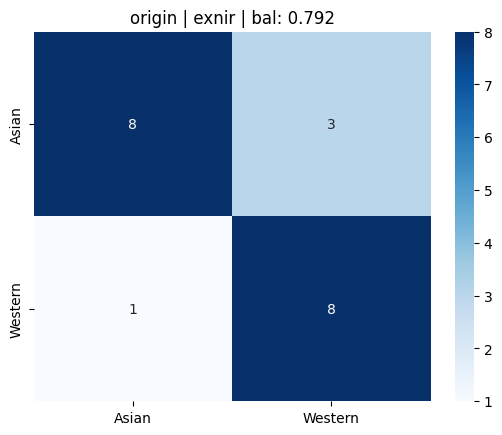

meta
100%|██████████| 250/250 [00:35<00:00,  7.12trial/s, best loss: 0.20833333333333337]
model                GaussianNB
balanced_accuracy      0.791667
f1_score               0.801587
precision              0.801587
recall                 0.801587
Name: meta, dtype: object


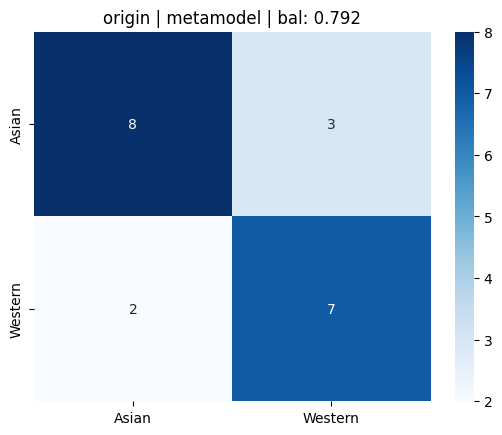

0.8055555555555554 0.7916666666666666 0.7916666666666666

PriceGroup
visnir
100%|██████████| 250/250 [00:26<00:00,  9.50trial/s, best loss: 0.1527777777777779] 
model                SNV-SG1D-Scaler-PCA-LogisticRegression
balanced_accuracy                                  0.847222
f1_score                                           0.849206
precision                                          0.849206
recall                                             0.849206
Name: visnir, dtype: object


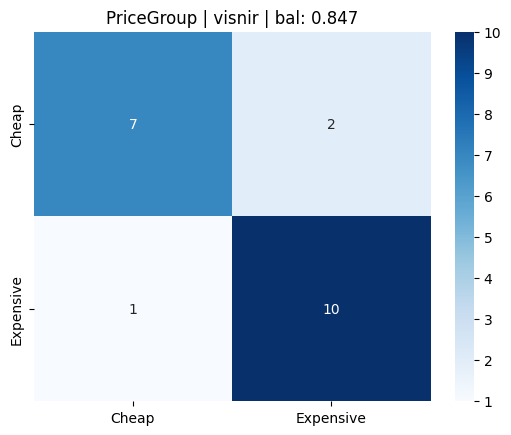

exnir
 97%|█████████▋| 242/250 [00:27<00:00,  8.65trial/s, best loss: 0.18055555555555558]
model                SG1D-Scaler-PCA-SVC
balanced_accuracy               0.819444
f1_score                        0.801587
precision                       0.801587
recall                          0.801587
Name: exnir, dtype: object


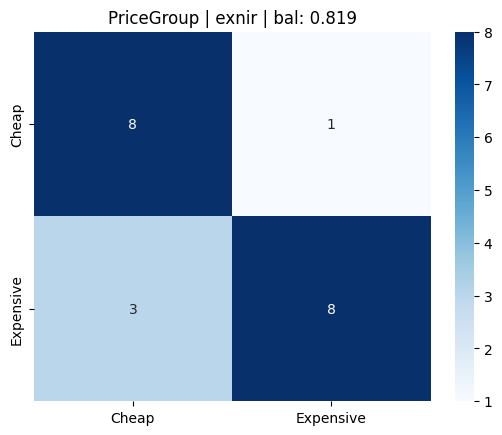

meta
100%|██████████| 250/250 [00:45<00:00,  5.51trial/s, best loss: 0.38888888888888895]
model                LogisticRegression
balanced_accuracy              0.611111
f1_score                        0.65873
precision                       0.65873
recall                          0.65873
Name: meta, dtype: object


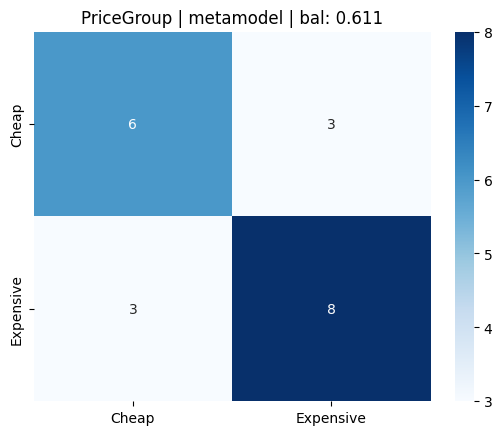

0.8472222222222221 0.8194444444444444 0.611111111111111

SaltLevel
visnir
100%|██████████| 250/250 [00:38<00:00,  6.56trial/s, best loss: 0.29166666666666663]
model                Detrend-Scaler-SVC
balanced_accuracy              0.708333
f1_score                       0.698413
precision                      0.698413
recall                         0.698413
Name: visnir, dtype: object


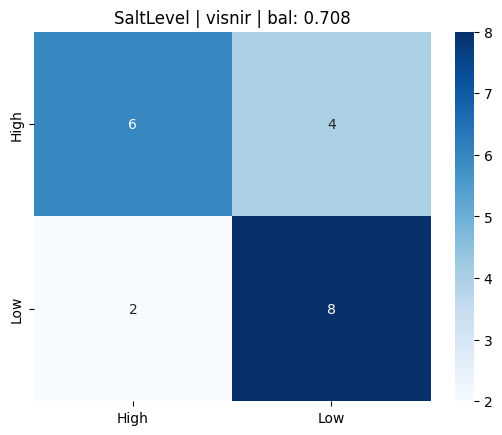

exnir
 97%|█████████▋| 243/250 [00:33<00:00,  7.25trial/s, best loss: 0.30555555555555547]
model                SG2D-Scaler-PCA-SVC
balanced_accuracy               0.694444
f1_score                        0.698413
precision                       0.698413
recall                          0.698413
Name: exnir, dtype: object


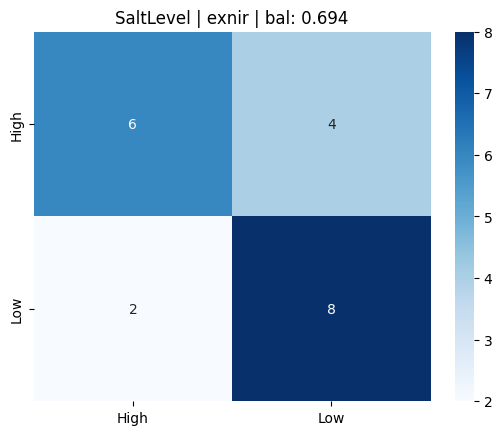

meta
 71%|███████   | 178/250 [00:38<00:15,  4.65trial/s, best loss: 0.27777777777777757]
model                LogisticRegression
balanced_accuracy              0.722222
f1_score                       0.698413
precision                      0.698413
recall                         0.698413
Name: meta, dtype: object


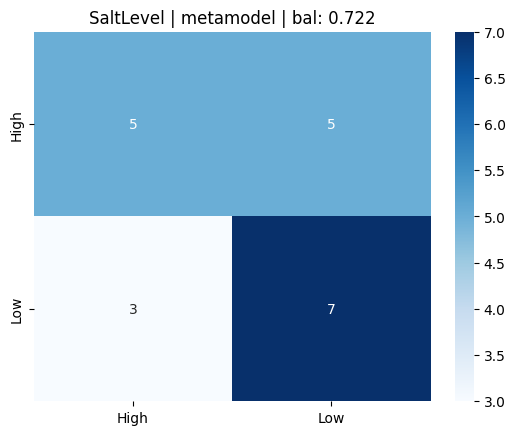

0.7083333333333334 0.6944444444444445 0.7222222222222224

ProteinPresence
visnir
100%|██████████| 250/250 [00:39<00:00,  6.41trial/s, best loss: 0.4361111111111111]
model                SNV-SG1D-Scaler-PCA-LogisticRegression
balanced_accuracy                                  0.563889
f1_score                                           0.650794
precision                                          0.650794
recall                                             0.650794
Name: visnir, dtype: object


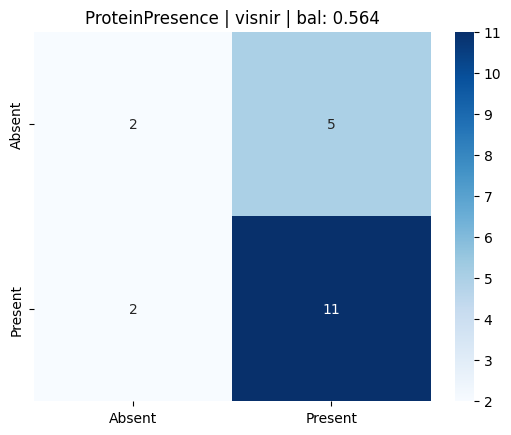

exnir
 72%|███████▏  | 179/250 [00:21<00:08,  8.20trial/s, best loss: 0.35277777777777775]
model                SG1D-Scaler-PCA-GaussianNB
balanced_accuracy                      0.647222
f1_score                               0.706349
precision                              0.706349
recall                                 0.706349
Name: exnir, dtype: object


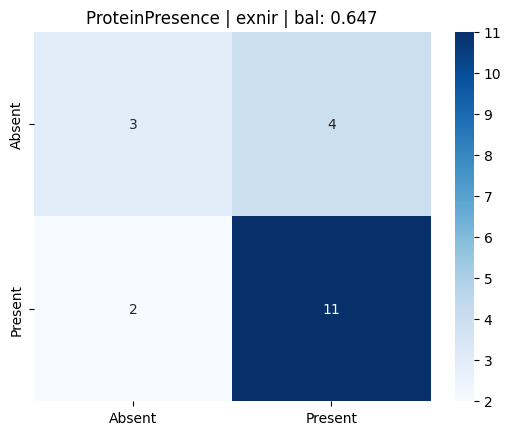

meta
100%|██████████| 250/250 [01:02<00:00,  4.00trial/s, best loss: 0.41666666666666663]
model                GaussianNB
balanced_accuracy      0.583333
f1_score               0.698413
precision              0.698413
recall                 0.698413
Name: meta, dtype: object


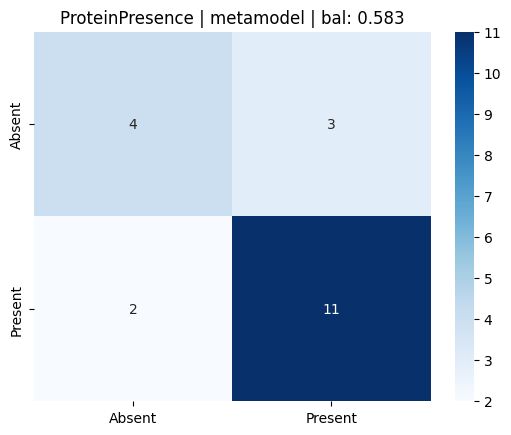

0.5638888888888889 0.6472222222222223 0.5833333333333334



In [ ]:
for label in labels:
    print(label)
    label_df = labels_df[['lot_id',label]]

    output_dir = Path(f"../model/predictions_classify/{label}")
    output_dir.mkdir(exist_ok=True, parents=True)

    X_visnir, X_exnir, y, datatype = preprocess_v2(input_df, label_df)
    encoder = LabelEncoder()
    encoded_y = pd.Series(encoder.fit_transform(y), index = y.index)

    # Run visnir segment (Qmini)
    print('visnir')
    trainer = initialise_trainer(task_type='classify', log=False)
    trainer.fit(X_visnir, encoded_y, kfold=DEFAULT_CV)
    score_visnir = trainer.get_best_performance()
    best_visnir = trainer.get_pipeline()
    metrics_visnir = generate_classify_metrics(trainer, name='visnir')
    trainer_visnir = trainer
    base_visnir = [best_visnir] # Wrapped in list format for meta step

    print(metrics_visnir)
    cnfm = generate_classify_confusionmatrix(best_visnir, X_visnir, encoded_y, encoder)
    f, ax = plt.subplots()
    sns.heatmap(cnfm, annot=True, ax=ax, cmap="Blues")
    ax.set(title=f'{label} | visnir | bal: {trainer_visnir.get_best_performance():.3f}')
    plt.savefig(output_dir/'confusion_matrix_visnir.png', bbox_inches='tight')
    plt.show()
    plt.close()

    # Run exnir segment (Qneo)
    print('exnir')
    trainer = initialise_trainer(task_type='classify', log=False)
    trainer.fit(X_exnir, encoded_y, kfold=DEFAULT_CV)
    score_exnir = trainer.get_best_performance()
    best_exnir = trainer.get_pipeline()
    metrics_exnir = generate_classify_metrics(trainer, name='exnir')
    trainer_exnir = trainer
    base_exnir = [best_exnir] # Wrapped in list format for meta step

    print(metrics_exnir)
    cnfm = generate_classify_confusionmatrix(best_exnir, X_exnir, encoded_y, encoder)
    f, ax = plt.subplots()
    sns.heatmap(cnfm, annot=True, ax=ax, cmap="Blues")
    ax.set(title=f'{label} | exnir | bal: {trainer_exnir.get_best_performance():.3f}')
    plt.savefig(output_dir/'confusion_matrix_exnir.png', bbox_inches='tight')
    plt.show()
    plt.close()

    # Prepare dataset for metamodel segment
    datasets = [X_visnir, X_exnir]
    estimators = [base_visnir, base_exnir] 
    X_meta, y_meta, split_idx = create_meta_datasets_splits(
        estimators=estimators, 
        datasets=datasets, 
        y=encoded_y, 
        groups=X_visnir.index, 
        outer_cv=DEFAULT_CV, 
        inner_cv=DEFAULT_CV,
        mode='classify',
    )

    # Run metamodel segment
    print('meta')
    cv_meta = CustomMetaSplitter(split_idx = split_idx)
    trainer = initialise_trainer(task_type='classify', log=False)
    trainer.fit(X_meta, y_meta, kfold=cv_meta, search_space=META_CLASSIFIER_PIPELINES, groups=X_meta.index)
    score_meta = trainer.get_best_performance()
    metrics_meta = generate_classify_metrics(trainer, name='meta')

    X_meta_final = generate_metafeatures_classify(datasets, estimators, y=encoded_y)
    X_meta_final = pd.DataFrame(X_meta_final, index=X_visnir.index)
    best_meta = trainer.get_pipeline()
    best_meta.fit(X_meta_final, encoded_y)
    trainer_meta = trainer

    print(metrics_meta)
    cnfm = generate_classify_confusionmatrix(best_meta, X_meta_final, encoded_y, encoder)
    f, ax = plt.subplots()
    sns.heatmap(cnfm, annot=True, ax=ax, cmap="Blues")
    ax.set(title=f'{label} | metamodel | bal: {trainer_meta.get_best_performance():.3f}')
    plt.savefig(output_dir/'confusion_matrix_meta.png', bbox_inches='tight')
    plt.show()
    plt.close()

    # Dump metrics to folder

    model_dump_classify(
        trainer=trainer_visnir, 
        estimator=best_visnir, 
        X=X_visnir,
        encoder=encoder, 
        encoded_y=encoded_y, 
        output_dir=output_dir, 
        suffix="_visnir",
    )

    model_dump_classify(
        trainer=trainer_exnir, 
        estimator=best_exnir, 
        X=X_exnir,
        encoder=encoder, 
        encoded_y=encoded_y, 
        output_dir=output_dir, 
        suffix="_exnir",
    )

    model_dump_classify(
        trainer=trainer_meta, 
        estimator=best_meta, 
        X=X_meta_final,
        encoder=encoder, 
        encoded_y=encoded_y, 
        output_dir=output_dir, 
        suffix="_meta",
    )
    
    print()



# individual runs

In [ ]:
X_visnir, X_exnir, y, datatype = preprocess_v2(input_df, labels_df)
encoder = LabelEncoder()
encoded_y = pd.Series(encoder.fit_transform(y), index = y.index)

### Training

In [ ]:
# Run visnir segment (Qmini)
trainer = initialise_trainer(task_type='classify', log=False)
trainer.fit(X_visnir, encoded_y, kfold=DEFAULT_CV)
score_visnir = trainer.get_best_performance()
best_visnir = trainer.get_pipeline()
metrics_visnir = generate_classify_metrics(trainer, name='visnir')
trainer_visnir = trainer
base_visnir = [best_visnir] # Wrapped in list format for meta step

In [ ]:
# Run exnir segment (Qneo)
trainer = initialise_trainer(task_type='classify', log=False)
trainer.fit(X_exnir, encoded_y, kfold=DEFAULT_CV)
score_exnir = trainer.get_best_performance()
best_exnir = trainer.get_pipeline()
metrics_exnir = generate_classify_metrics(trainer, name='exnir')
trainer_exnir = trainer
base_exnir = [best_exnir] # Wrapped in list format for meta step

In [ ]:
# Prepare dataset for metamodel segment
datasets = [X_visnir, X_exnir]
estimators = [base_visnir, base_exnir] 
X_meta, y_meta, split_idx = create_meta_datasets_splits(
    estimators=estimators, 
    datasets=datasets, 
    y=encoded_y, 
    groups=X_visnir.index, 
    outer_cv=DEFAULT_CV, 
    inner_cv=DEFAULT_CV,
    mode='classify',
)

# Run metamodel segment
cv_meta = CustomMetaSplitter(split_idx = split_idx)
trainer = initialise_trainer(task_type='classify', log=False)
trainer.fit(X_meta, y_meta, kfold=cv_meta, search_space=META_CLASSIFIER_PIPELINES, groups=X_meta.index)
score_meta = trainer.get_best_performance()
metrics_meta = generate_classify_metrics(trainer, name='meta')

X_meta_final = generate_metafeatures_classify(datasets, estimators, y=encoded_y)
X_meta_final = pd.DataFrame(X_meta_final, index=X_visnir.index)
best_meta = trainer.get_pipeline()
best_meta.fit(X_meta_final, encoded_y)
trainer_meta = trainer
print("Done")

### Metrics

In [ ]:
# Dump metrics to folder

model_dump_classify(
    trainer=trainer_visnir, 
    estimator=best_visnir, 
    X=X_visnir,
    encoder=encoder, 
    encoded_y=encoded_y, 
    output_dir=output_dir, 
    suffix="_visnir",
)

model_dump_classify(
    trainer=trainer_exnir, 
    estimator=best_exnir, 
    X=X_exnir,
    encoder=encoder, 
    encoded_y=encoded_y, 
    output_dir=output_dir, 
    suffix="_exnir",
)

model_dump_classify(
    trainer=trainer_meta, 
    estimator=best_meta, 
    X=X_meta_final,
    encoder=encoder, 
    encoded_y=encoded_y, 
    output_dir=output_dir, 
    suffix="_meta",
)



In [ ]:
# Review metrics without dumping
print(score_visnir, score_exnir, score_meta)

print()
print(metrics_visnir)
cnfm = generate_classify_confusionmatrix(best_visnir, X_visnir, encoded_y, encoder)
f, ax = plt.subplots()
sns.heatmap(cnfm, annot=True, ax=ax)
ax.set(title='visnir confusion matrix')
plt.show()

print()
print(metrics_exnir)
cnfm = generate_classify_confusionmatrix(best_exnir, X_exnir, encoded_y, encoder)
f, ax = plt.subplots()
sns.heatmap(cnfm, annot=True, ax=ax)
ax.set(title='exnir confusion matrix')
plt.show()

print()
print(metrics_meta)
cnfm = generate_classify_confusionmatrix(best_meta, X_meta_final, encoded_y, encoder)
f, ax = plt.subplots()
sns.heatmap(cnfm, annot=True, ax=ax)
ax.set(title='metamodel confusion matrix')
plt.show()
